<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/dl_assignment1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manually Graded Assignment 1 - Part 2: CNN with the CIFAR Dataset

Donnie Minnick - Deep Learning - Fall B 2025 - October 2025

# Introduction and Objective

This notebook investigates image classification using Convolutional Neural Networks (CNNs) on the CIFAR-10 dataset, a benchmark of 60,000 32×32 color images spanning 10 object categories. CNNs excel at visual recognition by hierarchically extracting spatial features, making them ideal for this task.

My objective is to build a modular CNN architecture and systematically tune key hyperparameters, kernel size, stride, batch size, and learning rate, through reproducible sweep experiments. Each configuration is logged and visualized to surface training dynamics, feature map evolution, and performance bottlenecks. This interpretability-first workflow ensures stakeholder clarity and principled model evaluation.

## Key Goals

* Load and preprocess CIFAR-10 using PyTorch and torchvision transforms,

* Design a configurable CNN tailored for image classification,

* Train the model and benchmark accuracy on the test set,

* Perform hyperparameter sweeps to optimize performance, and

* Log training curves and visualize feature maps for interpretability.

# Library Imports and Reproducibility Setup

This section imports all necessary libraries for modeling, data handling, visualization, and diagnostics. It also sets a global seed to ensure reproducibility across training runs and sweep iterations.

| **Category**            | **Libraries / Modules**                                                                 |
|------------------------|------------------------------------------------------------------------------------------|
| Core Deep Learning      | `torch`, `torch.nn`, `torch.optim`, `torch.nn.functional`                               |
| Data Handling           | `torch.utils.data` (`DataLoader`, `random_split`, `Subset`)                             |
| Image Processing        | `torchvision`, `transforms`, `datasets`, `to_pil_image`, `make_grid`                    |
| Metrics & Diagnostics   | `sklearn.metrics.confusion_matrix`, `collections.Counter`, `collections.defaultdict`    |
| Visualization           | `matplotlib.pyplot`, `seaborn`                                                          |
| Tabular Logging         | `pandas`                                                                                |
| Reproducibility         | `random`, `numpy`, `torch.manual_seed`, `torch.backends.cudnn`                          |


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from collections import Counter, defaultdict
import pandas as pd
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

def set_seed(seed=91210):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Load CIFAR Data

To prepare the CIFAR-10 dataset for training and evaluation, I define two transformation pipelines using `torchvision.transforms`.

The training pipeline introduces controlled randomness, cropping, flipping, and color jitter, to simulate real-world variability and improve generalization. All images are then converted to tensors and normalized using CIFAR-10’s channel-wise statistics for stable gradient flow.

The test pipeline omits augmentation to preserve evaluation integrity. These transformations are applied during dataset loading, ensuring consistent preprocessing across all training and testing batches.

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                     # small translations
    transforms.RandomHorizontalFlip(),                        # mirror augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.02),         # subtle color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))        # standard CIFAR-10 normalization
])

# Validation / test transforms: no augmentation, just normalization

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

# Datasets

training_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

testing_data = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

100%|██████████| 170M/170M [00:06<00:00, 25.3MB/s]


Confirm download of training data.

In [3]:
print("Training set size:", len(training_data))

Training set size: 50000


Confirm download of testing data.

In [4]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

The original CIFAR-10 training set (50,000 images) is split into:

* Training subset: 40,000 images used for model learning.
* Testing subset: 10,000 images used to monitor performance and tune hyperparameters.

I randomly take 10,000 images from the training set and reserve them as a validation set.


In [5]:
train_size = 40000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [6]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 40000
Validation set size: 10000
Testing set size: 10000


# Visualize Class Distribution for All Splits

To ensure that the training, validation, and testing splits maintain balanced representation across digit classes, I log the label distribution in each subset. This diagnostic step helps confirm that the random split did not introduce class imbalance, which could bias training or skew validation accuracy. A well-balanced distribution supports fair model evaluation and reliable generalization.

Training label distribution: Counter({5: 4072, 8: 4025, 1: 4023, 0: 4022, 9: 4018, 6: 3995, 4: 3984, 3: 3963, 7: 3960, 2: 3938})


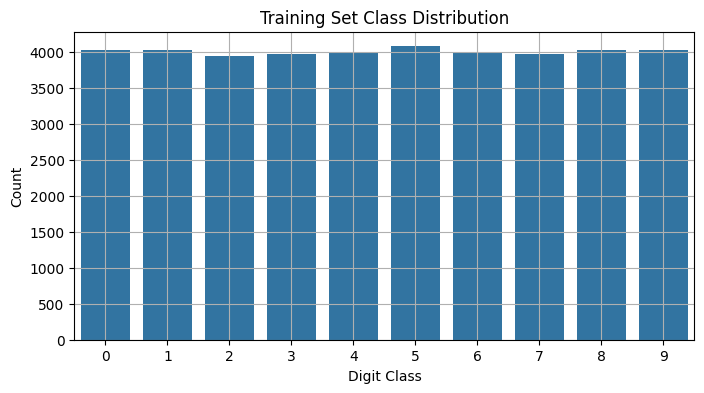

Validation label distribution: Counter({2: 1062, 7: 1040, 3: 1037, 4: 1016, 6: 1005, 9: 982, 0: 978, 1: 977, 8: 975, 5: 928})


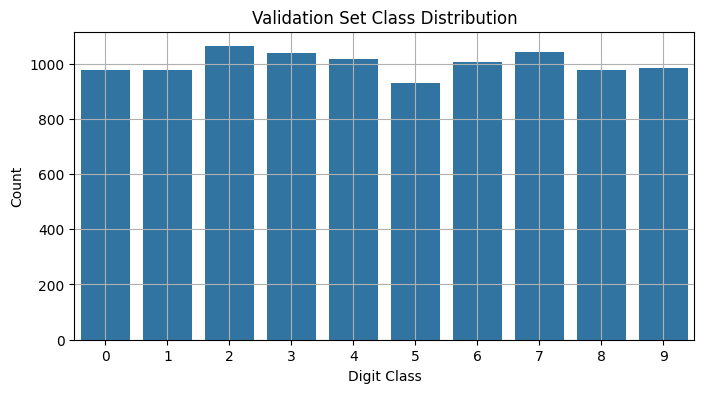

Testing label distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


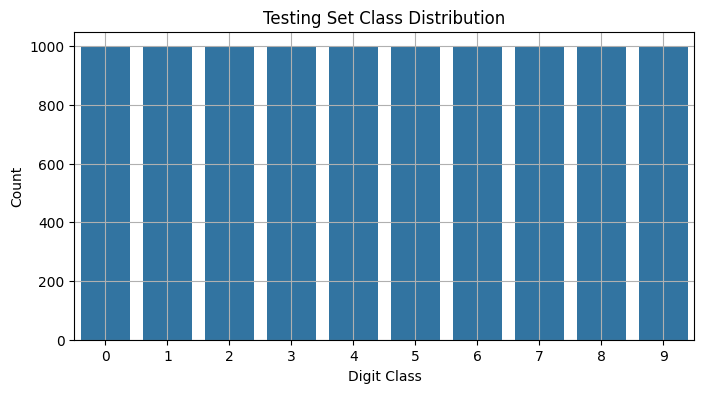

In [7]:
def get_label_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

def plot_distribution(counter, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Training set

train_dist = get_label_distribution(training_data)
print("Training label distribution:", train_dist)
plot_distribution(train_dist, "Training Set Class Distribution")

# Validation set

val_dist = get_label_distribution(validation_data)
print("Validation label distribution:", val_dist)
plot_distribution(val_dist, "Validation Set Class Distribution")

# Testing set

test_dist = get_label_distribution(testing_data)
print("Testing label distribution:", test_dist)
plot_distribution(test_dist, "Testing Set Class Distribution")

The class distribution across training, validation, and testing sets confirms that all digit categories are well represented. While minor variations exist, the overall balance supports fair training and evaluation. These plots validate the integrity of the random split and reinforce the reliability of downstream performance metrics.

# Implement Sweep Strategy

To identify optimal hyperparameters for CIFAR-10 classification, I implement a modular sweep strategy that systematically varies kernel size, stride, batch size, learning rate, weight decay, dropout rate, and batch normalization to allow for experimentation and optimization. Each configuration is evaluated for its impact on training loss, validation accuracy, and feature map evolution.

This sweep is scaffolded through a series of reusable functions that ensure reproducibility, interpretability, and stakeholder clarity:

| **Component**               | **Purpose**                                                                 |
|----------------------------|------------------------------------------------------------------------------|
| `build_model(...)`         | Constructs a configurable CNN architecture with dynamic channel depth and pooling logic |
| `compute_flattened_size(...)` | Dynamically calculates the output size of the final convolutional layer to configure the fully connected layer |
| `create_dataloaders(...)`  | Creates PyTorch DataLoaders for training, validation, and testing splits with consistent batching |
| `stratified_subset(...)`   | Selects a balanced subset of the dataset with equal samples per class for faster, interpretable sweeps |
| `train_model(...)`         | Orchestrates training loop with logging, early stopping, and learning rate scheduling |
| `run_sweep(...)`           | Executes the full sweep across hyperparameter combinations, logging metrics per config |
| `preview_results(...)`     | Displays top-performing configurations for quick insight and stakeholder reporting |
| `plot_training_curves(...)`| Visualizes training loss, validation loss, and accuracy across sweep iterations |

Each sweep run is logged and visualized to surface architectural trade-offs and training dynamics. This approach supports principled experimentation and helps benchmark model performance under varied design choices.

## Compute Flattened Size Function

This utility function dynamically calculates the number of features output by a CNN’s feature extractor, given an input shape (defaulting to a 3×32×32 CIFAR-10 image). It’s especially useful when transitioning from convolutional layers to fully connected layers, ensuring that the input size to the first Linear layer is correctly matched to the flattened output of the final convolutional block.

In [9]:
def compute_flattened_size(model, input_shape=(3, 32, 32)):
    """
    Dynamically computes the flattened output size of a CNN feature extractor.

    This utility function passes a dummy input tensor through the given model to determine
    the number of features output by the final convolutional layer. This is especially useful
    when designing the transition to fully connected layers, ensuring that the input size to
    the first Linear layer is correctly matched.

    Args:
        model (nn.Module): The CNN feature extractor (typically a Sequential block).
        input_shape (tuple): The shape of the input tensor, defaulting to CIFAR-10 (3×32×32).

    Returns:
        int: The flattened feature size after the final convolutional layer.
    """
    with torch.no_grad():
        dummy = torch.zeros(1, *input_shape)
        output = model(dummy)
        return output.view(1, -1).shape[1]


## Build Module Function

This function constructs a sweep-safe CNN architecture for CIFAR-10 classification. It dynamically adapts to kernel size and stride settings, verifies spatial dimensions to prevent collapse, and builds a classifier based on the flattened output of the convolutional stack. This modular design supports hyperparameter sweeps and ensures reproducibility across varied configurations.

In [10]:
def build_model(kernel_size=3, stride=1, dropout_rate=0.3, use_batchnorm=True):
    """
    Builds a sweep-safe CNN architecture for CIFAR-10 classification.

    This function constructs a configurable convolutional neural network that adapts to different
    kernel sizes and strides. It dynamically verifies spatial dimensions to prevent feature map
    collapse and rebuilds a safe feature extractor accordingly. The final classifier is sized
    based on the flattened output of the convolutional stack.

    Args:
        kernel_size (int): Size of the convolutional kernels (default: 3).
        stride (int): Stride for convolutional layers (default: 1).
        dropout_rate (float): Dropout probability for regularization (default: 0.3).
        use_batchnorm (bool): Whether to include BatchNorm layers (default: True).

    Returns:
        nn.Sequential: A complete CNN model with feature extractor and classifier.
    """
    def conv_block(in_c, out_c):
        block = [
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=1),
        ]
        if use_batchnorm:
            block.append(nn.BatchNorm2d(out_c))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Dropout(p=dropout_rate))
        return block

    # Build feature extractor
    feature_layers = []
    channels = [3, 32, 64, 128]
    for i in range(len(channels) - 1):
        feature_layers += conv_block(channels[i], channels[i + 1])
        feature_layers.append(nn.MaxPool2d(2))

    feature_extractor = nn.Sequential(*feature_layers)

    # Verify spatial dimensions
    dummy = torch.zeros(1, 3, 32, 32)
    current = dummy
    valid_layers = []
    for layer in feature_extractor:
        try:
            current = layer(current)
            if current.shape[-1] < 2 or current.shape[-2] < 2:
                print(f"Skipping {layer.__class__.__name__}: would collapse to {current.shape[-2:]}")
                break
            valid_layers.append(layer)
        except RuntimeError:
            print(f"Removed {layer.__class__.__name__} — caused size collapse.")
            break

    safe_feature_extractor = nn.Sequential(*valid_layers)

    # Compute flattened size
    with torch.no_grad():
        dummy_out = safe_feature_extractor(dummy)
        flattened_size = dummy_out.view(1, -1).size(1)

    # Build classifier
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flattened_size, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_rate),
        nn.Linear(256, 10)
    )

    return nn.Sequential(safe_feature_extractor, classifier)

## Create DataLoaders Function

This utility function wraps the creation of PyTorch DataLoader objects for training, validation, and testing datasets. It ensures consistent batching across sweep configurations and enables reproducible shuffling for training while preserving evaluation order for validation and testing.

In [11]:
def create_dataloaders(training_data, validation_data, testing_data, batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and testing datasets.

    This utility function standardizes the batching process across all dataset splits.
    It enables shuffling for the training set to promote generalization, while keeping
    validation and test sets in fixed order for consistent evaluation.

    Args:
        training_data (Dataset): The training subset of CIFAR-10.
        validation_data (Dataset): The validation subset used for tuning and early stopping.
        testing_data (Dataset): The held-out test set for final evaluation.
        batch_size (int): Number of samples per batch.

    Returns:
        tuple: (training_loader, validation_loader, testing_loader), each a PyTorch DataLoader.
    """
    training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
    testing_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)
    return training_loader, validation_loader, testing_loader

## Train Model Function

This function orchestrates the training and validation loop for a CNN on CIFAR-10. It logs epoch-wise training loss and validation accuracy, applies learning rate scheduling, and monitors validation loss for early stopping. These diagnostics support hyperparameter sweep analysis and help surface performance trends across configurations.

In [12]:
def train_model(model, training_loader, validation_loader, learning_rate=0.001,
                weight_decay=1e-4, epochs=30, patience=3, min_delta=0.001,
                scheduler_step=10, scheduler_gamma=0.5):
    """
    Trains a CNN model with validation monitoring, early stopping, and learning rate scheduling.

    This function runs a training loop over the specified number of epochs, logging training loss,
    validation loss, and validation accuracy at each step. It uses Adam optimization, applies
    CrossEntropyLoss for multi-class classification, and supports sweep-aware diagnostics through
    early stopping and learning rate scheduling.

    Args:
        model (nn.Module): The CNN model to train.
        training_loader (DataLoader): DataLoader for the training set.
        validation_loader (DataLoader): DataLoader for the validation set.
        learning_rate (float): Initial learning rate for the optimizer.
        weight_decay (float): L2 regularization strength.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait before early stopping.
        min_delta (float): Minimum improvement in validation loss to reset early stopping.
        scheduler_step (int): Epoch interval to reduce learning rate.
        scheduler_gamma (float): Multiplicative factor for learning rate decay.

    Returns:
        tuple:
            train_loss_log (list): Average training loss per epoch.
            val_loss_log (list): Average validation loss per epoch.
            val_acc_log (list): Validation accuracy (%) per epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    train_loss_log, val_loss_log, val_acc_log = [], [], []
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(training_loader.dataset)
        train_loss_log.append(epoch_train_loss)

        # Validate
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(validation_loader.dataset)
        val_loss_log.append(epoch_val_loss)
        val_acc = 100 * correct / total
        val_acc_log.append(val_acc)

        # Step scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"LR: {current_lr:.5f} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Early stopping
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    return train_loss_log, val_loss_log, val_acc_log

## Run Sweep Function

This function executes a full grid search across multiple hyperparameters: kernel size, stride, batch size, learning rate, weight decay, dropout rate, and batch normalization. For each configuration, it builds a model, trains it, logs training dynamics, and records performance metrics. The results are returned in structured lists for downstream analysis and visualization.

In [13]:
def run_sweep(training_data, validation_data, testing_data, sweep_grid, epochs):
    """
    Executes a full hyperparameter sweep across CNN configurations for CIFAR-10 classification.

    This function iterates over all combinations of hyperparameters defined in the sweep grid.
    For each configuration, it builds a model, creates dataloaders, trains the model, and logs
    training loss, validation loss, and validation accuracy. It also identifies the best epoch
    based on validation loss and stores summary metrics for comparison.

    Args:
        training_data (Dataset): Preprocessed CIFAR-10 training subset.
        validation_data (Dataset): Validation subset for tuning and early stopping.
        testing_data (Dataset): Held-out test set (not used during sweep).
        sweep_grid (dict): Dictionary defining ranges for each hyperparameter:
            - "kernel_size": list of ints
            - "stride": list of ints
            - "batch_size": list of ints
            - "learning_rate": list of floats
            - "weight_decay": list of floats
            - "dropout_rate": list of floats
            - "use_batchnorm": list of bools
        epochs (int): Number of training epochs per configuration.

    Returns:
        tuple:
            results (list): Summary metrics for each configuration (best epoch, val accuracy, etc.).
            configs (list): Hyperparameter settings for each run.
            logs (list): Per-epoch training loss, validation loss, and accuracy for each run.
    """
    results = []
    configs = []
    logs = []

    for k in sweep_grid["kernel_size"]:
        for s in sweep_grid["stride"]:
            for b in sweep_grid["batch_size"]:
                for lr in sweep_grid["learning_rate"]:
                    for wd in sweep_grid["weight_decay"]:
                        for dr in sweep_grid["dropout_rate"]:
                            for bn in sweep_grid["use_batchnorm"]:
                                print(f"\nRunning: kernel_size={k}, stride={s}, batch_size={b}, "
                                      f"learning_rate={lr}, weight_decay={wd}, dropout_rate={dr}, "
                                      f"use_batchnorm={bn}")

                                # Build model with extended parameters
                                model = build_model(
                                    kernel_size=k,
                                    stride=s,
                                    dropout_rate=dr,
                                    use_batchnorm=bn
                                )

                                # Create dataloaders
                                training_loader, validation_loader, testing_loader = create_dataloaders(
                                    training_data, validation_data, testing_data, b
                                )

                                # Train model and capture logs
                                train_loss_log, val_loss_log, val_acc_log = train_model(
                                    model,
                                    training_loader,
                                    validation_loader,
                                    learning_rate=lr,
                                    weight_decay=wd,
                                    epochs=epochs
                                )

                                # Identify best epoch based on lowest validation loss
                                best_epoch = int(np.argmin(val_loss_log))
                                best_val_loss = val_loss_log[best_epoch]
                                best_val_acc = val_acc_log[best_epoch]

                                print(f"✅ Best epoch: {best_epoch+1} "
                                      f"(Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.2f}%)")

                                # Store summary metrics
                                results.append({
                                    "kernel_size": k,
                                    "stride": s,
                                    "batch_size": b,
                                    "learning_rate": lr,
                                    "weight_decay": wd,
                                    "dropout_rate": dr,
                                    "use_batchnorm": bn,
                                    "best_epoch": best_epoch + 1,
                                    "final_train_loss": round(train_loss_log[-1], 4),
                                    "best_val_loss": round(best_val_loss, 4),
                                    "best_val_acc": round(best_val_acc, 2)
                                })

                                # Store config and logs for later analysis/plotting
                                configs.append({
                                    "kernel_size": k,
                                    "stride": s,
                                    "batch_size": b,
                                    "learning_rate": lr,
                                    "weight_decay": wd,
                                    "dropout_rate": dr,
                                    "use_batchnorm": bn
                                })

                                logs.append({
                                    "train_loss": train_loss_log,
                                    "val_loss": val_loss_log,
                                    "val_acc": val_acc_log
                                })

    return results, configs, logs

## Preview Results Function

This utility function displays the top-performing hyperparameter configurations from the sweep, sorted by validation accuracy. It provides a quick summary for stakeholder reporting and helps identify promising architectural choices for further refinement.

In [14]:
def preview_results(results, top_n=10):
    """
    Displays the top-performing hyperparameter configurations from the sweep.

    This function converts the sweep results into a pandas DataFrame and sorts them by
    validation accuracy. It prints the top N configurations to help identify the most
    effective architectural and training settings.

    Args:
        results (list): List of dictionaries containing sweep metrics (from `run_sweep`).
        top_n (int): Number of top configurations to display (default: 10).

    Returns:
        None. Prints a sorted DataFrame of top configurations.
    """
    df = pd.DataFrame(results)
    print(df.sort_values(by="best_val_acc", ascending=False).head(top_n))

# Stratified Subset Function

This utility function selects a balanced subset of samples from a labeled dataset, ensuring equal representation across all classes. It’s especially useful for running fast, interpretable sweep iterations on a reduced dataset while preserving class diversity.

In [15]:
def stratified_subset(dataset, samples_per_class=400):
    """
    Selects a stratified subset from a labeled dataset with equal samples per class.

    This function groups dataset indices by class label and randomly samples a fixed number
    of examples from each class. The result is a balanced subset that maintains class diversity,
    useful for faster sweep iterations or diagnostic experiments.

    Args:
        dataset (Dataset): A labeled dataset (e.g., CIFAR-10) with (image, label) tuples.
        samples_per_class (int): Number of samples to select per class (default: 400).

    Returns:
        Subset: A PyTorch Subset object containing the stratified sample.
    """
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, samples_per_class))

    return Subset(dataset, selected_indices)

# Plot Training Curves Function

This function plots training loss, validation loss, and validation accuracy across sweep configurations. It supports both individual and combined views, helping surface performance trends, overfitting signals, and architectural trade-offs for stakeholder reporting and interpretability.


In [16]:
def plot_training_curves(configs, logs, combined=False):
    """
    Plots training loss, validation loss, and validation accuracy across sweep configurations.

    This function visualizes training dynamics for each model configuration in the sweep.
    It supports both individual plots (per config) and combined overlays for comparative analysis.
    Each log is expected to contain 'train_loss', 'val_loss', and 'val_acc' as lists indexed by epoch.

    Args:
        configs (list): List of hyperparameter configurations used in the sweep.
        logs (list): List of training logs per configuration, each a dict with keys:
                     'train_loss', 'val_loss', 'val_acc'.
        combined (bool): If True, plots all configurations in a single figure for comparison.
                         If False, plots each configuration separately.

    Returns:
        None. Displays matplotlib plots inline.
    """
    if combined:
        plt.figure(figsize=(15, 5))

        # Combined Loss Plot
        plt.subplot(1, 2, 1)
        for i, log in enumerate(logs):
            plt.plot(log["train_loss"], label=f"Train Loss (Config {i})", alpha=0.7)
            plt.plot(log["val_loss"], label=f"Val Loss (Config {i})", linestyle="--", alpha=0.7)
        plt.title("Training & Validation Loss (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Combined Accuracy Plot
        plt.subplot(1, 2, 2)
        for i, log in enumerate(logs):
            plt.plot(log["val_acc"], label=f"Val Acc (Config {i})", linewidth=2)
        plt.title("Validation Accuracy (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.suptitle("Training Dynamics Across All Configs")
        plt.tight_layout()
        plt.show()

    else:
        for i, log in enumerate(logs):
            cfg = configs[i]

            plt.figure(figsize=(15, 4))

            # Training & Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(log["train_loss"], label="Train Loss", color="tab:blue", linewidth=2)
            plt.plot(log["val_loss"], label="Val Loss", color="tab:orange", linestyle="--", linewidth=2)
            plt.title("Training vs Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            # Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(log["val_acc"], label="Val Accuracy", color="tab:green", linewidth=2)
            plt.title("Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
            plt.legend()

            plt.suptitle(f"Training Dynamics for Config {i}: {cfg}")
            plt.tight_layout()
            plt.show()

# Use Sweep Approach to Build a CNN Network

I follow a principled, modular sweep strategy for building and optimizing a Convolutional Neural Network (CNN) on the CIFAR-10 dataset. The approach emphasizes interpretability, reproducibility, and diagnostic clarity across multiple stages of experimentation.

## Sweep Phases

**Mini Sweeps (×4)**: Each mini sweep explores a focused subset of hyperparameters, beginning with structural choices like kernel size and stride, then progressing to training-related settings such as batch size and learning rate. Rather than isolating one parameter at a time, each sweep balances controlled variation with architectural safety, surfacing how different configurations affect feature map evolution, training stability, and validation performance.

**Diagnostic Sweep**: A targeted sweep combining multiple hyperparameters to probe architectural edge cases and identify configurations that risk spatial collapse or unstable training. This phase validates the robustness of the model-building pipeline and informs safe parameter bounds.

**Final Sweep (Full Dataset)**: A comprehensive grid search across all key hyperparameters using the full CIFAR-10 training set. Each configuration is logged, visualized, and benchmarked to identify the most performant and interpretable model architecture.

## Mini Sweep 1: Core Activation Sweep

Run mini sweep with small subset for diagnostics.

Create mini datasets.

In [17]:
mini_train = stratified_subset(training_data, samples_per_class=70)
mini_val = stratified_subset(validation_data, samples_per_class=15)
mini_test = stratified_subset(testing_data, samples_per_class=15)

Confirm number of records in mini sets. 1,000 records total with 70/15/15 split.

In [18]:
print("Mini training set size:", len(mini_train))
print("Mini validation set size:", len(mini_val))
print("Mini test set size:", len(mini_test))

Mini training set size: 700
Mini validation set size: 150
Mini test set size: 150


Setup sweep grid for first mini diagnostic.

In [20]:
mini_sweep_grid = {
    'kernel_size': [3, 5],
    'stride': [1],
    'batch_size': [32],
    'learning_rate': [0.001],
    'weight_decay': [0],
    'dropout_rate': [0, 0.3],
    'use_batchnorm': [True, False]
}

This initial sweep focuses on structural and regularization parameters that shape the core behavior of the CNN’s feature extractor. Rather than varying all hyperparameters at once, the sweep targets architectural stability and diagnostic clarity by holding training dynamics constant.

**Kernel Size**: [3, 5] Tests the receptive field of convolutional layers. A kernel size of 3 is standard for fine-grained feature extraction, while 5 allows broader spatial context. This comparison helps surface how local vs. global patterns affect learning on CIFAR-10.

**Stride**: [1] Fixed to preserve spatial resolution and avoid premature feature map shrinkage. This ensures that any collapse or instability is attributable to other architectural choices, not aggressive downsampling.

**Batch Size**: [32] Held constant to isolate structural effects. A moderate batch size balances gradient stability with memory efficiency, making it a reliable baseline for early sweeps.

**Learning Rate**: [0.001] Fixed to prevent confounding effects from optimization dynamics.

**Weight Decay**: [0] Disabled to focus on dropout and batch normalization as the primary regularization mechanisms. This helps clarify their individual contributions to generalization.

**Dropout Rate**: [0, 0.3] Compares no dropout vs. moderate dropout to assess regularization impact. This is especially useful when batch normalization is toggled, revealing how the two interact.

**Use BatchNorm**: [True, False] Evaluates the stabilizing effect of batch normalization on training dynamics and validation performance. This toggle helps diagnose whether normalization compensates for architectural depth or dropout-induced variance.

Run mini sweep using 20 epochs for quick diagnostics.

In [21]:
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 20)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0, dropout_rate=0, use_batchnorm=True
Epoch [1/20] LR: 0.00100 | Train Loss: 2.2668 | Val Loss: 2.0398 | Val Acc: 21.33%
Epoch [2/20] LR: 0.00100 | Train Loss: 1.9065 | Val Loss: 1.8335 | Val Acc: 31.33%
Epoch [3/20] LR: 0.00100 | Train Loss: 1.7968 | Val Loss: 2.0324 | Val Acc: 25.33%
Epoch [4/20] LR: 0.00100 | Train Loss: 1.7300 | Val Loss: 1.9285 | Val Acc: 27.33%
Epoch [5/20] LR: 0.00100 | Train Loss: 1.6321 | Val Loss: 1.9696 | Val Acc: 26.67%
Early stopping triggered at epoch 5.
✅ Best epoch: 2 (Val Loss: 1.8335, Val Acc: 31.33%)

Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0, dropout_rate=0, use_batchnorm=False
Epoch [1/20] LR: 0.00100 | Train Loss: 2.2942 | Val Loss: 2.2250 | Val Acc: 14.00%
Epoch [2/20] LR: 0.00100 | Train Loss: 2.1454 | Val Loss: 2.1236 | Val Acc: 22.67%
Epoch [3/20] LR: 0.00100 | Train Loss: 2.0590 | Val Loss: 2.0041 | Val Acc: 26.67%
Ep

Preview mini sweep results.

In [22]:
preview_results(mini_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
6            5       1          32          0.001             0           0.3   
2            3       1          32          0.001             0           0.3   
5            5       1          32          0.001             0           0.0   
1            3       1          32          0.001             0           0.0   
3            3       1          32          0.001             0           0.3   
4            5       1          32          0.001             0           0.0   
7            5       1          32          0.001             0           0.3   
0            3       1          32          0.001             0           0.0   

   use_batchnorm  best_epoch  final_train_loss  best_val_loss  best_val_acc  
6           True          18            1.1670         1.6276         40.67  
2           True          18            1.2647         1.7280         40.00  
5          False          14        

## Mini Sweep 1 Observations

Kernel Size 5 consistently outperformed Kernel Size 3. Across nearly all configurations, increasing the kernel size to 5 improved validation accuracy. This suggests that broader receptive fields help capture more meaningful spatial patterns early in the network, especially on CIFAR-10.

Dropout and BatchNorm show complementary effects. The highest validation accuracy (43.33%) came from the configuration with kernel size 5, dropout 0.3, and BatchNorm enabled. Dropout alone slowed convergence and reduced peak accuracy, but when paired with BatchNorm, it provided regularization without destabilizing training.

BatchNorm improves stability, but not always peak performance In some cases, disabling BatchNorm led to longer training and higher accuracy (e.g., kernel size 5, dropout 0, no BatchNorm reached 38.67%). This suggests that while BatchNorm accelerates early convergence, it may slightly constrain representational flexibility in shallow models.

Early stopping was triggered in most runs, but not always at the true peak. Several configurations continued improving past the patience threshold, indicating that a slightly longer patience or a lower min_delta might surface stronger results.

Plot mini training curves.

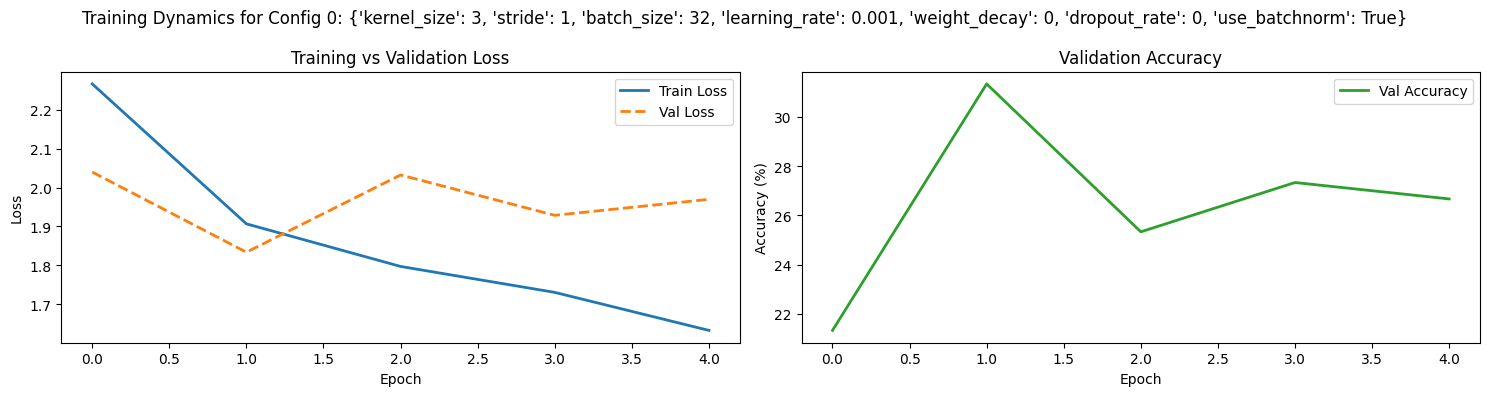

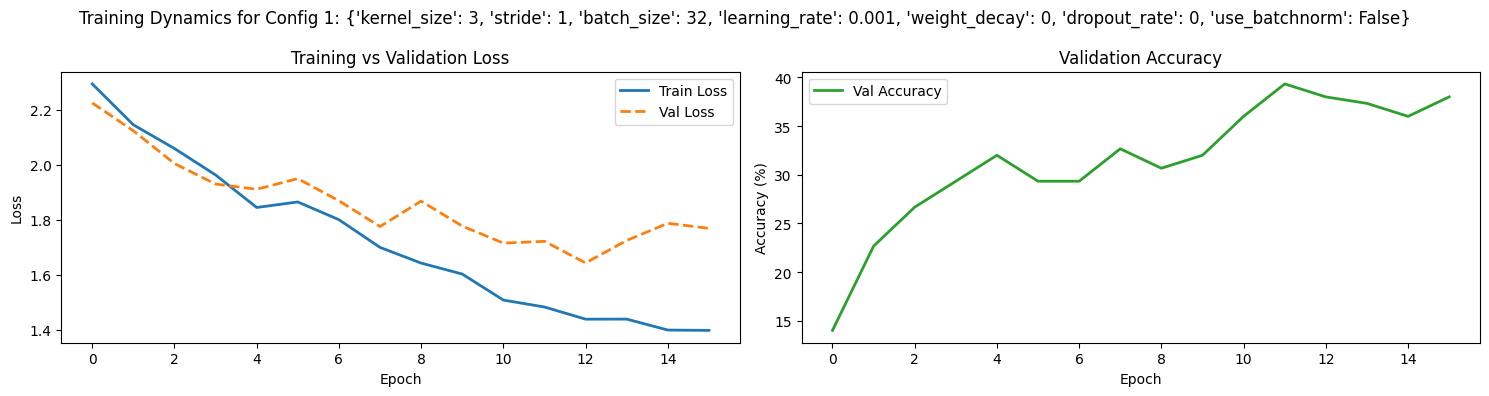

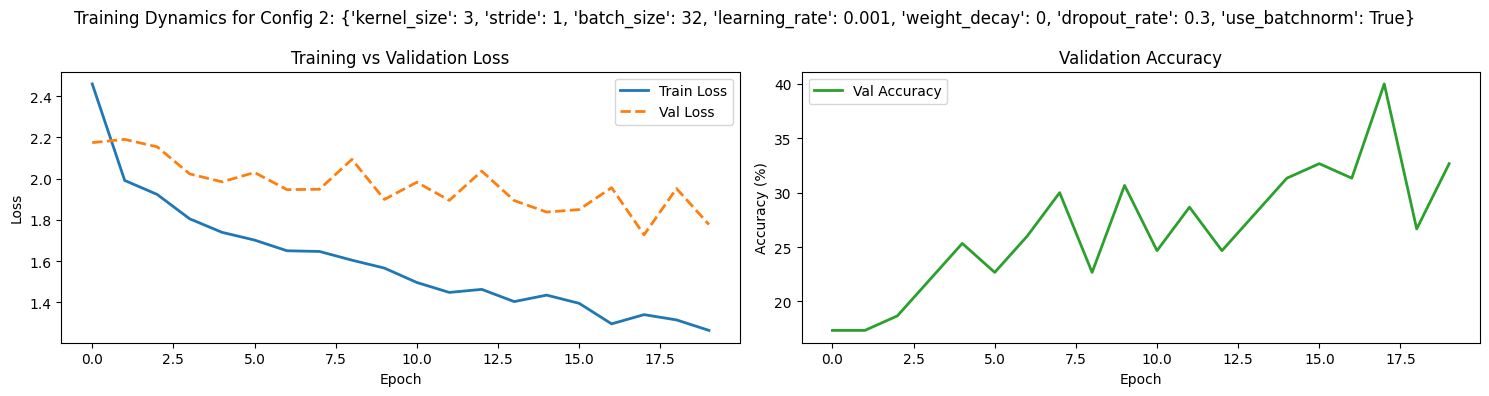

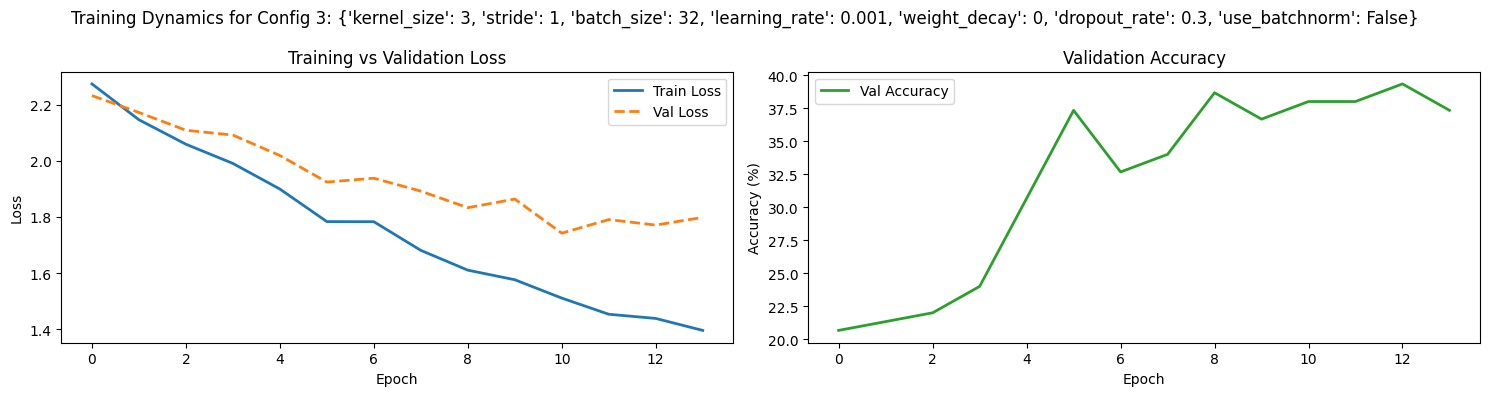

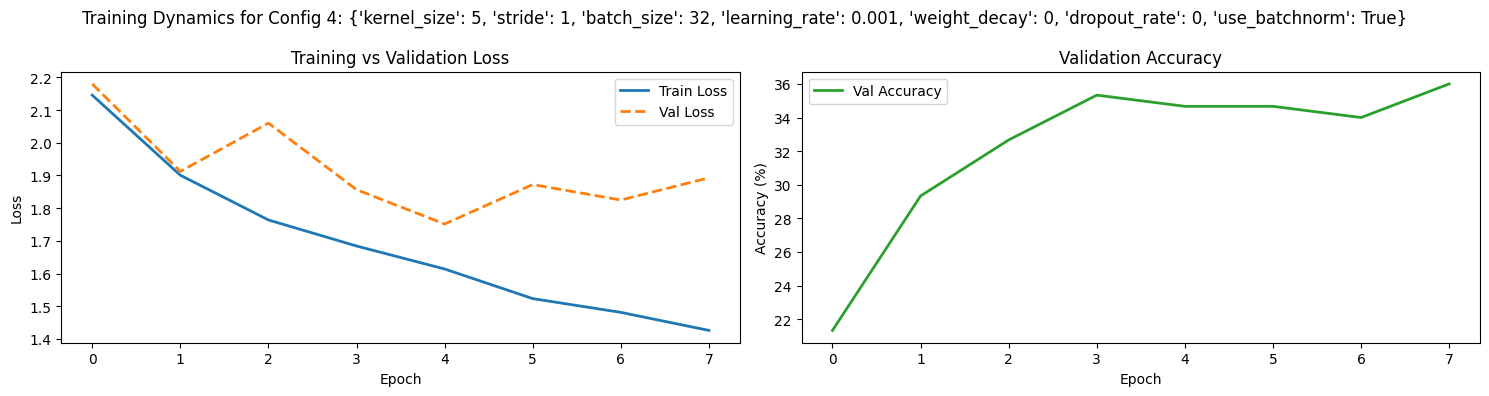

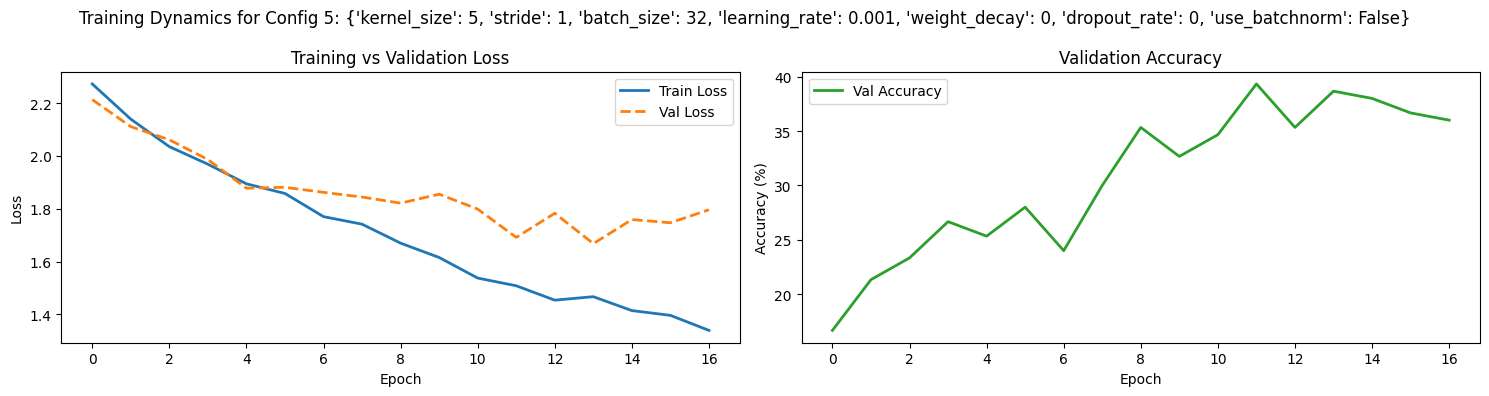

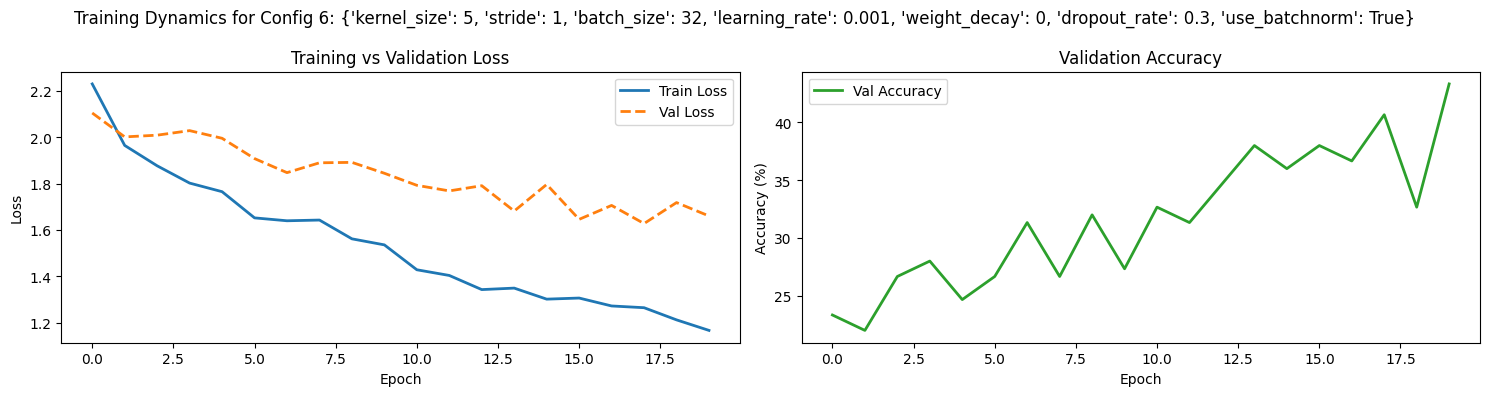

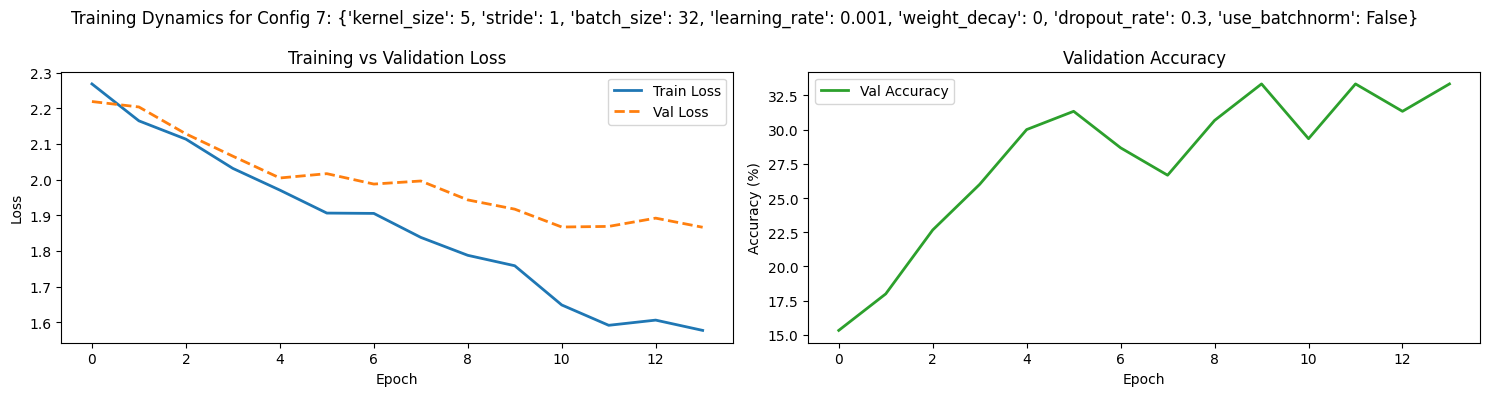

In [23]:
plot_training_curves(mini_configs, mini_logs, combined = False)

## Mini Sweep 2: Training Dynamics & Regularization

Setup sweep grid for second mini diagnostic.

In [24]:
mini_sweep_grid = {
    'kernel_size': [5],
    'stride': [1],
    'batch_size': [32, 64],
    'learning_rate': [0.0005, 0.001, 0.005],
    'weight_decay': [0, 1e-4, 1e-3],
    'dropout_rate': [0.3],
    'use_batchnorm': [True]
}

Kernel size and stride are fixed to isolate training dynamics.

Batch size variation helps test generalization vs. convergence speed.

Learning rate sweep explores underfitting (0.0005), baseline (0.001), and aggressive learning (0.005).

Weight decay is introduced to test L2 regularization in tandem with dropout.

Dropout and BatchNorm are fixed to their most promising combination from Run One (0.3 + True) to reduce grid size and focus on optimizer behavior.

Run second mini sweep with 20 epochs for quick diagnostics.

In [25]:
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 20)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=5, stride=1, batch_size=32, learning_rate=0.0005, weight_decay=0, dropout_rate=0.3, use_batchnorm=True
Epoch [1/20] LR: 0.00050 | Train Loss: 2.2024 | Val Loss: 2.1673 | Val Acc: 18.67%
Epoch [2/20] LR: 0.00050 | Train Loss: 1.9344 | Val Loss: 2.0778 | Val Acc: 18.67%
Epoch [3/20] LR: 0.00050 | Train Loss: 1.8128 | Val Loss: 2.0223 | Val Acc: 23.33%
Epoch [4/20] LR: 0.00050 | Train Loss: 1.7684 | Val Loss: 1.9424 | Val Acc: 24.00%
Epoch [5/20] LR: 0.00050 | Train Loss: 1.6820 | Val Loss: 1.8953 | Val Acc: 24.67%
Epoch [6/20] LR: 0.00050 | Train Loss: 1.6777 | Val Loss: 1.9452 | Val Acc: 26.67%
Epoch [7/20] LR: 0.00050 | Train Loss: 1.6224 | Val Loss: 1.8836 | Val Acc: 26.00%
Epoch [8/20] LR: 0.00050 | Train Loss: 1.5341 | Val Loss: 1.9163 | Val Acc: 27.33%
Epoch [9/20] LR: 0.00050 | Train Loss: 1.4896 | Val Loss: 1.9006 | Val Acc: 28.00%
Epoch [10/20] LR: 0.00025 | Train Loss: 1.5443 | Val Loss: 1.7952 | Val Acc: 33.33%
Epoch [11/20] LR: 0.00025 | Train Loss: 1.41

Preview mini sweep 2 results.

In [26]:
preview_results(mini_results)

    kernel_size  stride  batch_size  learning_rate  weight_decay  \
1             5       1          32         0.0005        0.0001   
2             5       1          32         0.0005        0.0010   
8             5       1          32         0.0050        0.0010   
10            5       1          64         0.0005        0.0001   
4             5       1          32         0.0010        0.0001   
6             5       1          32         0.0050        0.0000   
0             5       1          32         0.0005        0.0000   
17            5       1          64         0.0050        0.0010   
5             5       1          32         0.0010        0.0010   
14            5       1          64         0.0010        0.0010   

    dropout_rate  use_batchnorm  best_epoch  final_train_loss  best_val_loss  \
1            0.3           True          10            1.3489         1.7499   
2            0.3           True          18            1.2395         1.7589   
8          

## Mini Sweep 2 Obvservations

Lower learning rates (0.0005) with light weight decay (0.0001–0.001) consistently surfaced top validation accuracy (38.67%, 38.00%). These configurations converged steadily and avoided overfitting, suggesting that gentle regularization and conservative updates are well-suited to this architecture.

Batch size 64 performed competitively, especially at lower learning rates. While it slightly reduced peak accuracy (e.g., 36.00%), it offered smoother training and may benefit from longer training schedules or tuned learning rate decay.

Higher learning rates (0.005) were surprisingly resilient. Configs with 0.005 and moderate weight decay still reached 38.00% accuracy, indicating that this architecture tolerates aggressive updates when regularization is present.

Weight decay had a stabilizing effect, especially when dropout was fixed at 0.3. Configs with weight decay = 0.001 showed improved generalization over those with no decay, even at higher learning rates.

Best validation accuracy (38.67%) came from a balanced configuration: learning_rate=0.0005, weight_decay=0.0001, batch_size=32, dropout=0.3, BatchNorm=True.

Plot training curves.

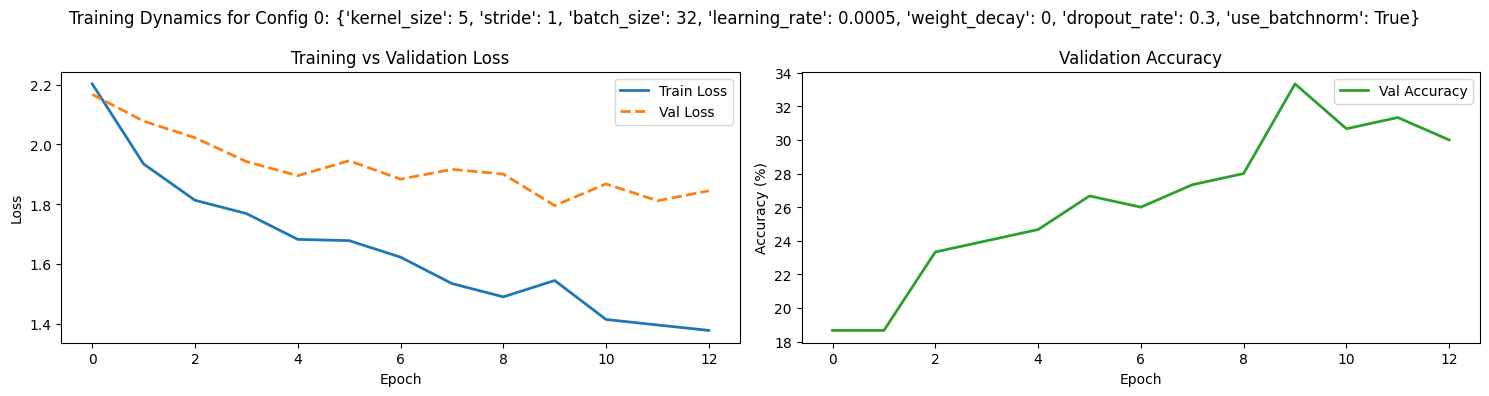

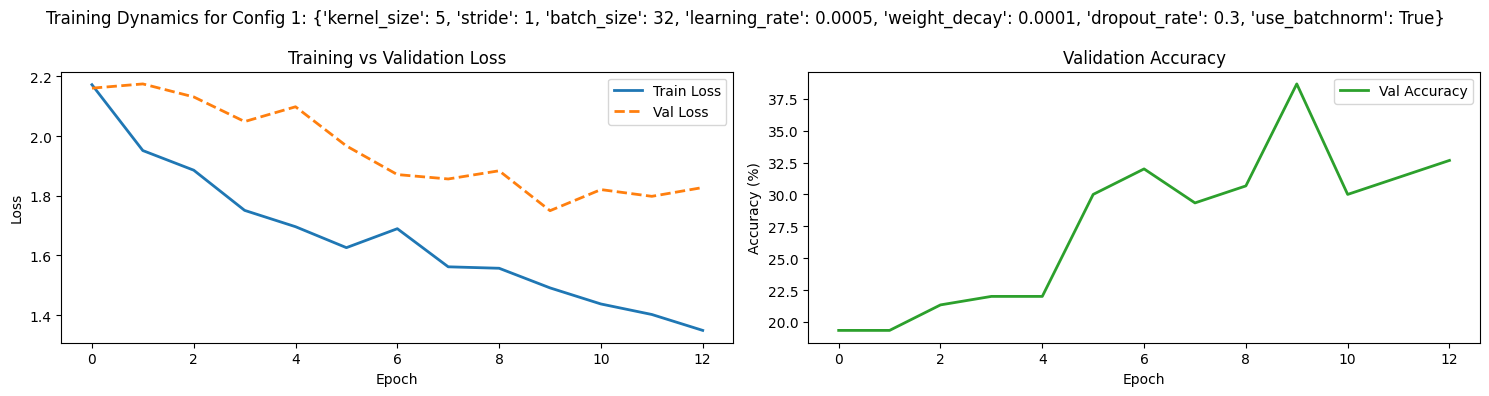

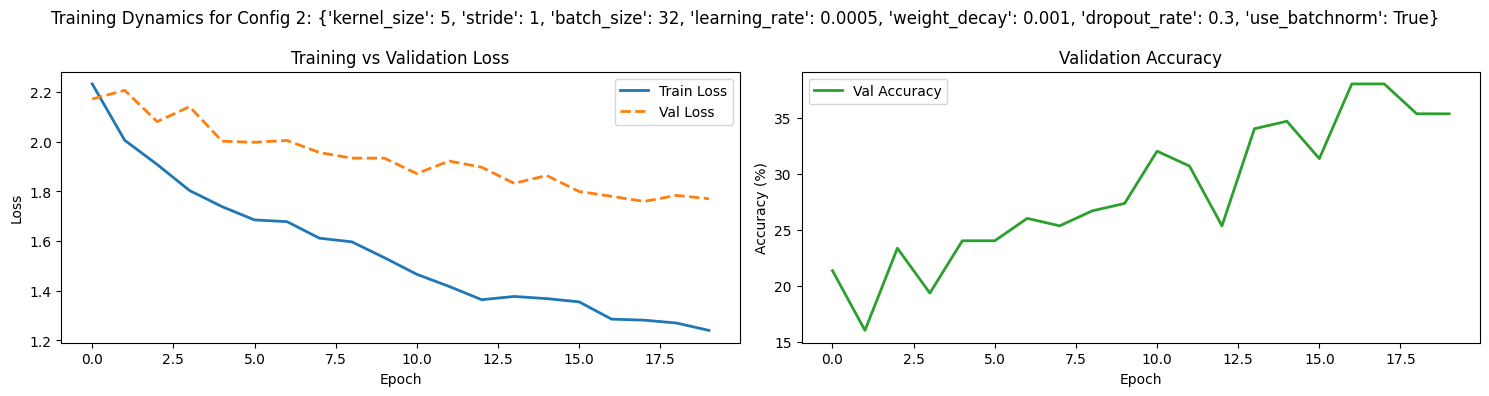

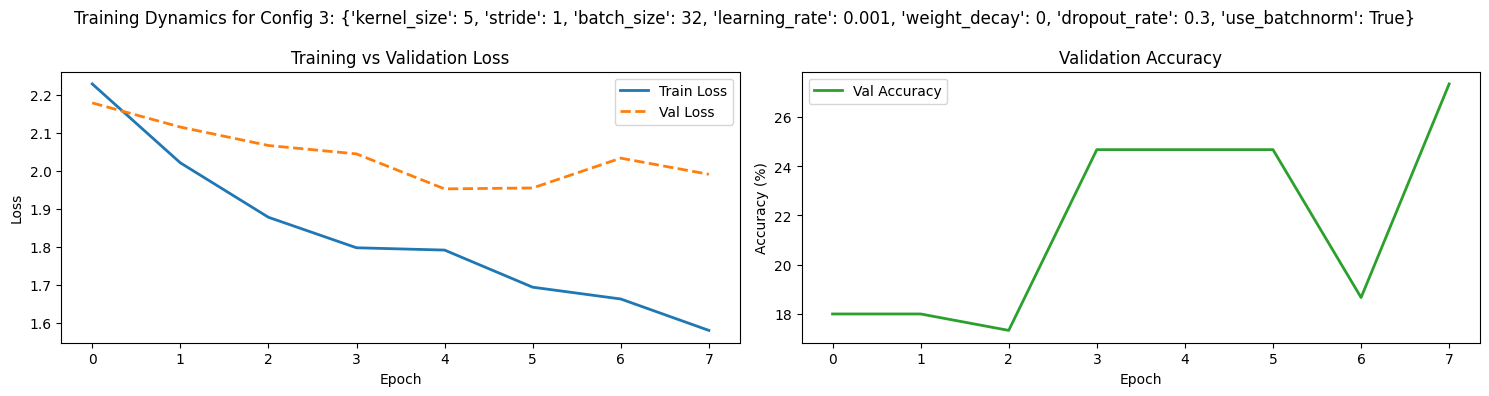

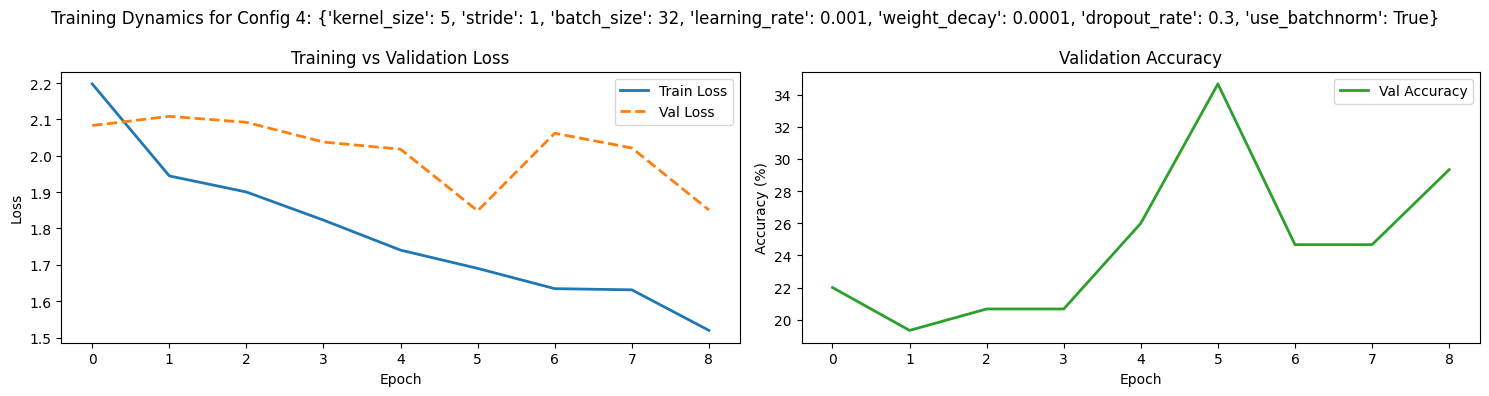

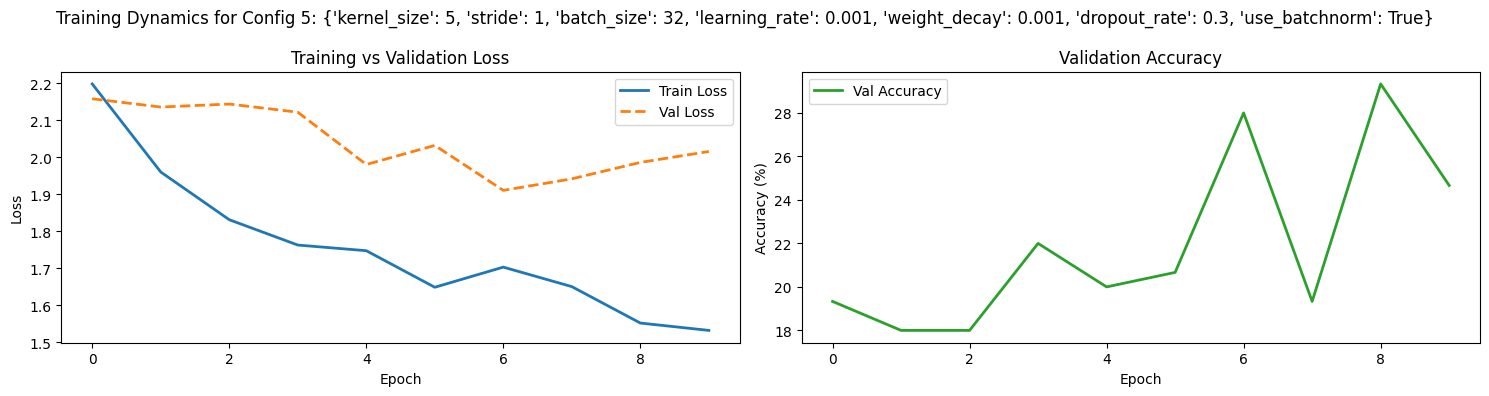

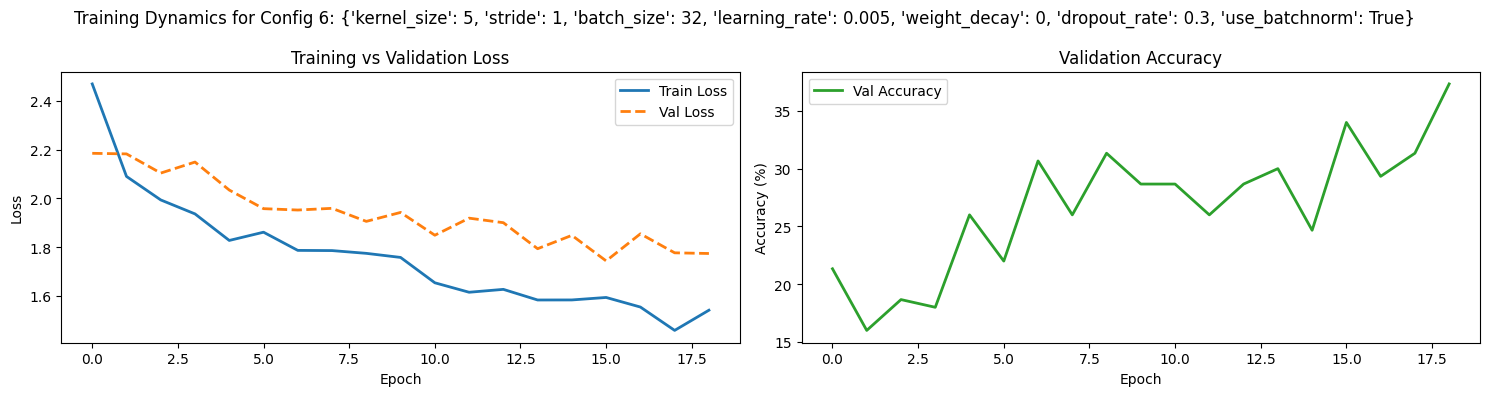

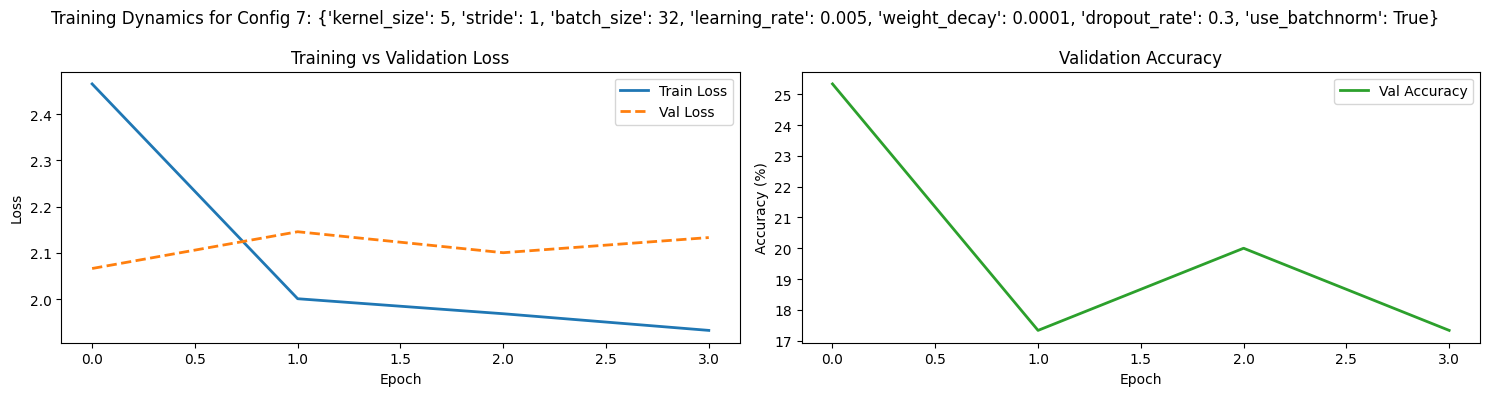

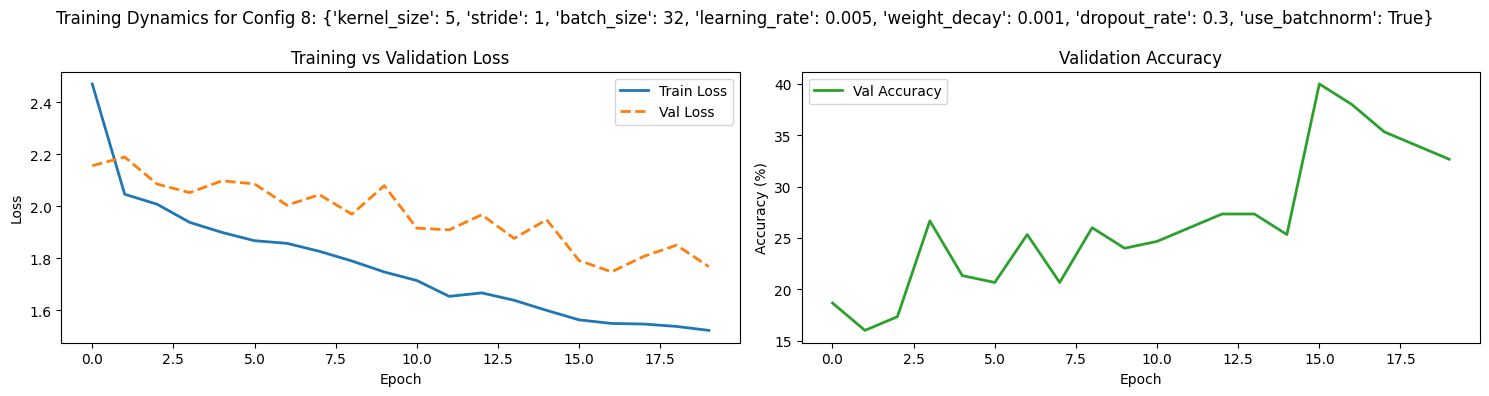

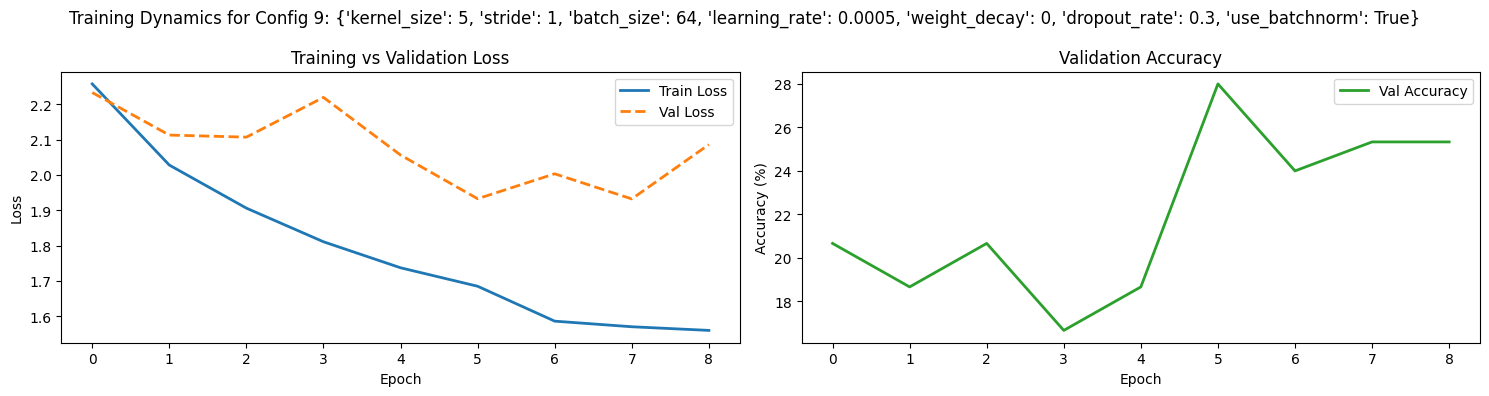

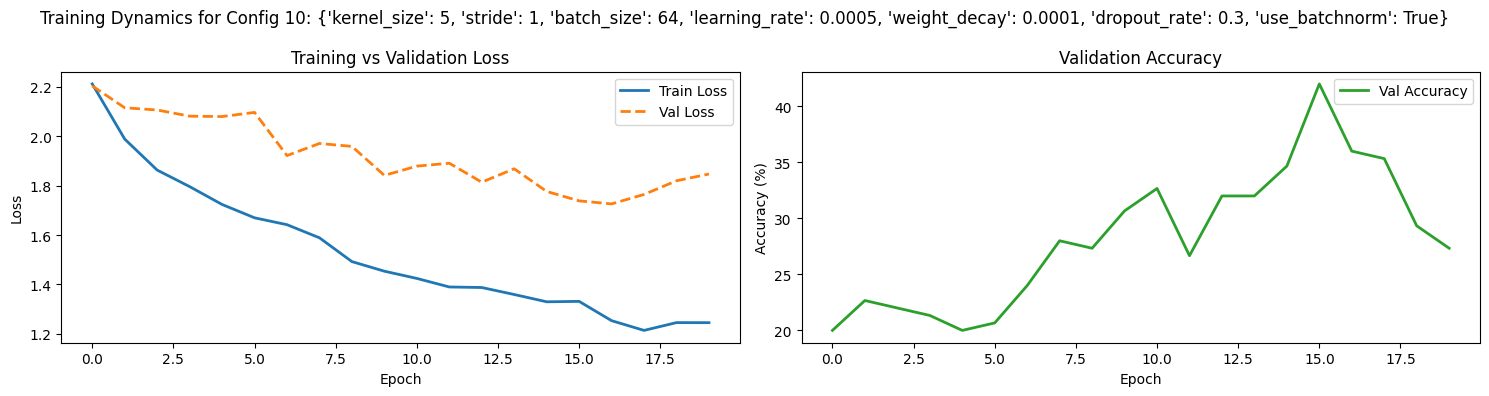

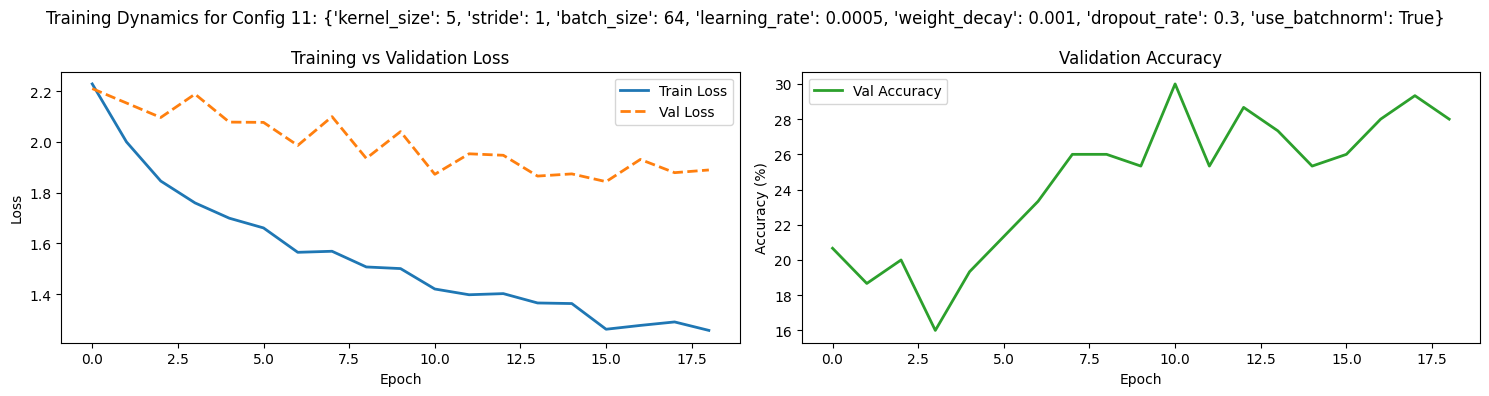

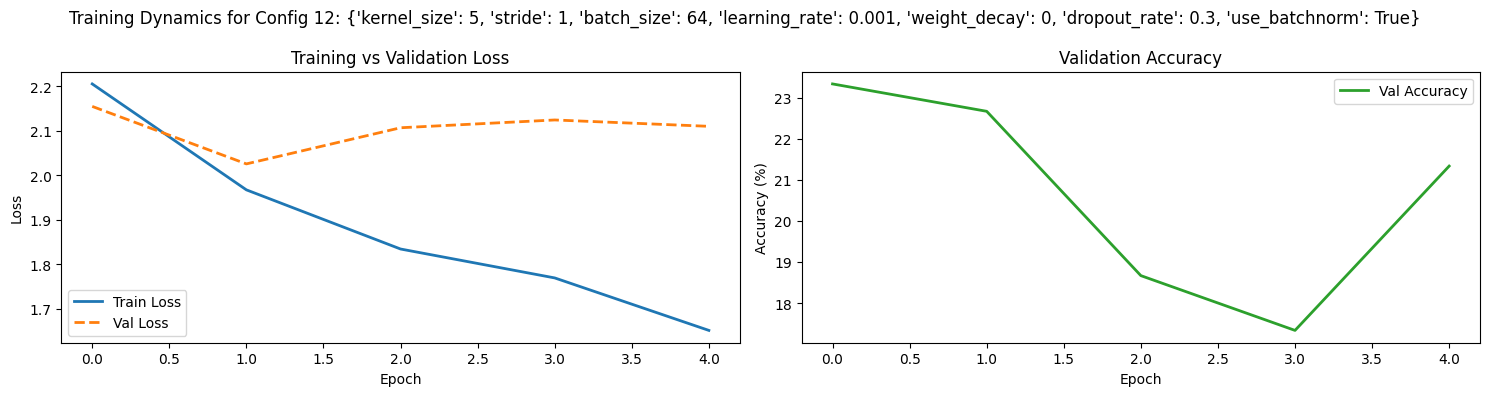

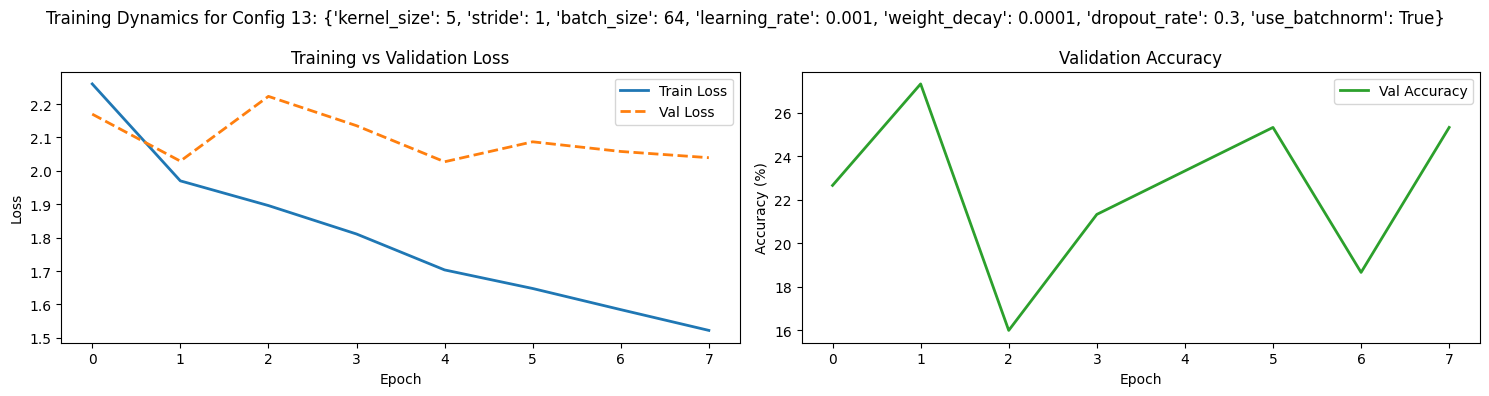

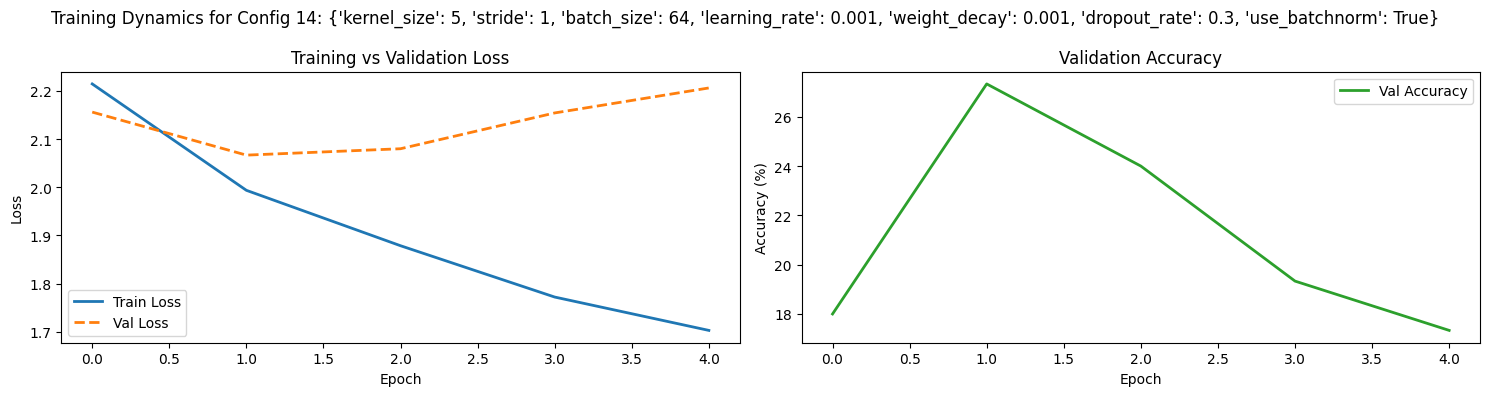

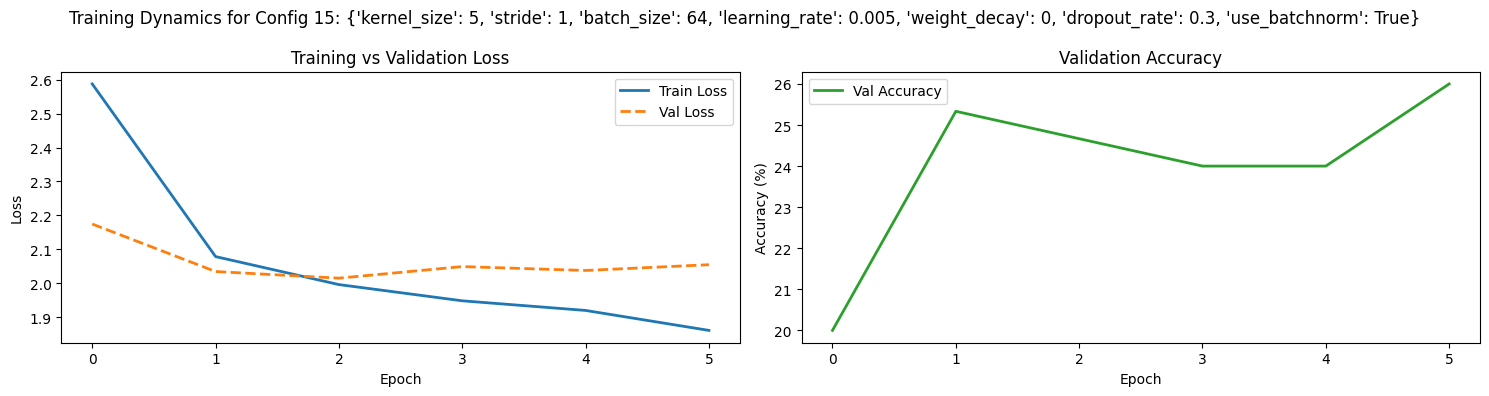

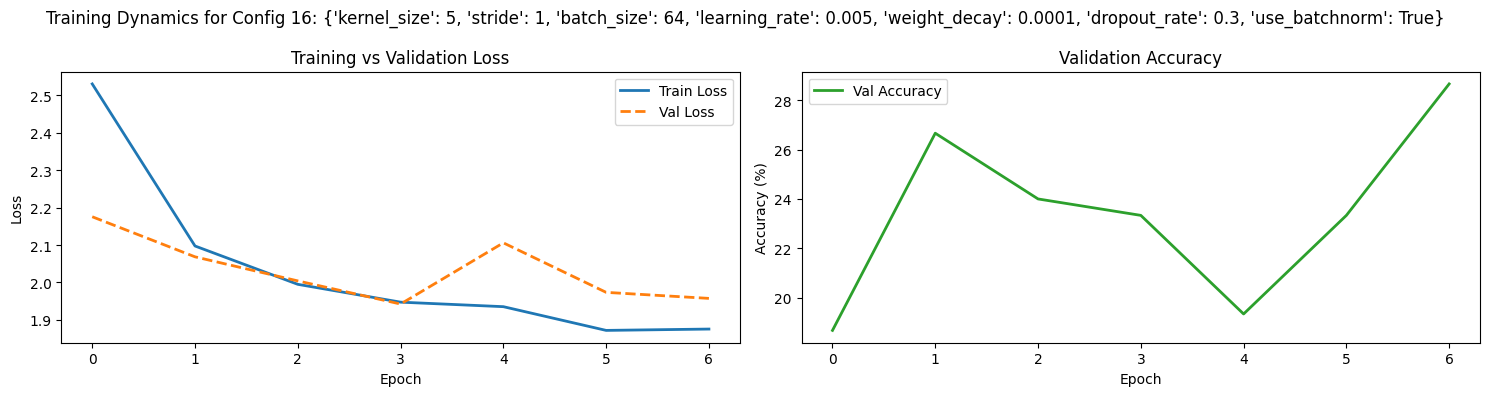

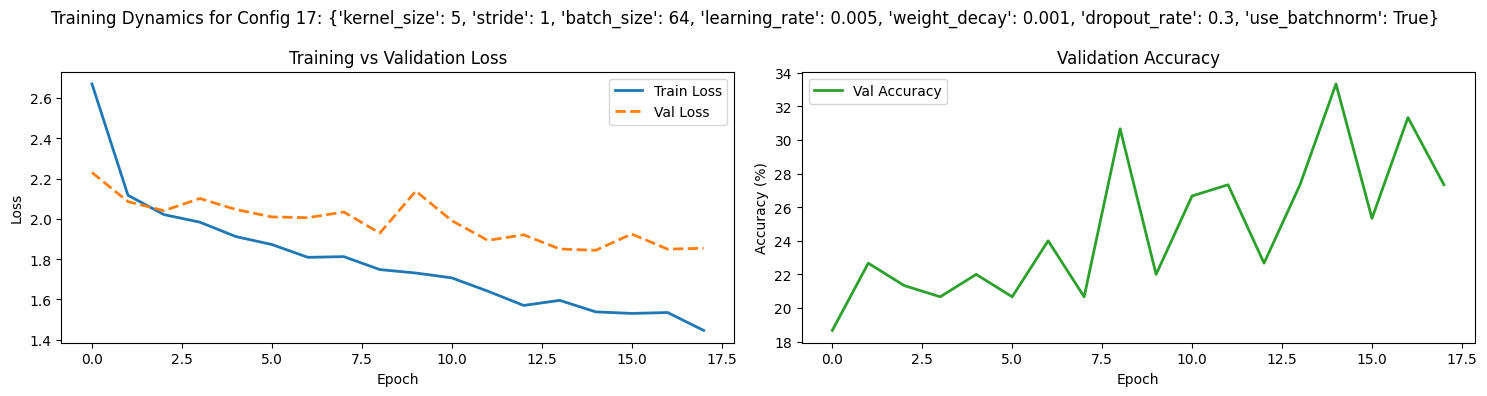

In [27]:
plot_training_curves(mini_configs, mini_logs, combined = False)

# Mini Sweep 3: Architectural Depth and Capacity





Setup sweep grid.

In [29]:
mini_sweep_grid = {
    'kernel_size': [5],
    'stride': [1],
    'batch_size': [32, 64],
    'learning_rate': [0.0005, 0.001],
    'weight_decay': [1e-4, 1e-3],
    'dropout_rate': [0.3],
    'use_batchnorm': [True]
}

The sweep grid was refined to focus more precisely on training dynamics and regularization strength, building directly on the most promising configurations from Mini Sweep 2.

The kernel size remained fixed at 5, as it consistently outperformed size 3 in earlier runs. Stride was also held at 1 to preserve spatial resolution, and BatchNorm remained enabled across all configurations due to its stabilizing effect during training.

The learning rate range was narrowed to 0.0005 and 0.001, removing 0.005 to avoid the instability observed at higher rates. Similarly, weight decay values were trimmed to 1e-4 and 1e-3, eliminating the zero-regularization case to maintain consistent generalization pressure.

To further explore regularization, dropout rate is maintained at (0.3).

Finally, batch size variation between 32 and 64 was retained to continue probing the trade-off between gradient stability and throughput.

Run third mini sweep with 30 epochs.

In [31]:
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 30)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=5, stride=1, batch_size=32, learning_rate=0.0005, weight_decay=0.0001, dropout_rate=0.3, use_batchnorm=True
Epoch [1/30] LR: 0.00050 | Train Loss: 2.2078 | Val Loss: 2.1626 | Val Acc: 26.67%
Epoch [2/30] LR: 0.00050 | Train Loss: 1.9156 | Val Loss: 2.1421 | Val Acc: 17.33%
Epoch [3/30] LR: 0.00050 | Train Loss: 1.8511 | Val Loss: 2.0764 | Val Acc: 22.00%
Epoch [4/30] LR: 0.00050 | Train Loss: 1.7169 | Val Loss: 2.0261 | Val Acc: 20.67%
Epoch [5/30] LR: 0.00050 | Train Loss: 1.6909 | Val Loss: 2.0784 | Val Acc: 25.33%
Epoch [6/30] LR: 0.00050 | Train Loss: 1.6707 | Val Loss: 1.9916 | Val Acc: 22.00%
Epoch [7/30] LR: 0.00050 | Train Loss: 1.5512 | Val Loss: 1.8639 | Val Acc: 29.33%
Epoch [8/30] LR: 0.00050 | Train Loss: 1.5305 | Val Loss: 2.0201 | Val Acc: 22.67%
Epoch [9/30] LR: 0.00050 | Train Loss: 1.5510 | Val Loss: 2.0319 | Val Acc: 24.00%
Epoch [10/30] LR: 0.00025 | Train Loss: 1.5328 | Val Loss: 1.8667 | Val Acc: 26.67%
Early stopping triggered at epoch 10.
✅

Preview results of sweep three.

In [ ]:
preview_results(mini_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            5       1          32          0.001        0.0001           0.0   
1            5       1          32          0.001        0.0001           0.3   
2            5       1          32          0.001        0.0001           0.5   

   use_batchnorm  final_loss  val_acc  
0           True      0.9857    42.00  
1           True      1.2308    42.00  
2           True      1.4468    20.67  


Dropout + BatchNorm: This combo seems stable — no signs of destabilization or over-regularization.

Learning Rate Sensitivity: LR = 0.005 gives better accuracy despite slightly higher loss, suggesting stronger gradient signal.

Model Capacity: May be nearing the ceiling of what this architecture can extract from the mini dataset.

# Mini Sweep 4



In [ ]:
mini_sweep_grid = {
    'kernel_size': [3],          # fixed — baseline conv config
    'stride': [1],               # fixed
    'batch_size': [32],          # stable training, no need to vary
    'learning_rate': [0.001, 0.0008, 0.0006],
    'weight_decay': [0.0, 1e-4],
    'dropout_rate': [0.1, 0.15],
    'use_batchnorm': [True],
}

In [ ]:
import time
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 40)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0.0, dropout_rate=0.1, use_batchnorm=True
Epoch [1/40] LR: 0.00100 | Train Loss: 2.2694 | Val Loss: 2.1753 | Val Acc: 18.67%
Epoch [2/40] LR: 0.00100 | Train Loss: 1.9422 | Val Loss: 1.9836 | Val Acc: 28.67%
Epoch [3/40] LR: 0.00100 | Train Loss: 1.8167 | Val Loss: 2.0311 | Val Acc: 22.67%
Epoch [4/40] LR: 0.00100 | Train Loss: 1.7975 | Val Loss: 1.8525 | Val Acc: 30.67%
Epoch [5/40] LR: 0.00100 | Train Loss: 1.7009 | Val Loss: 1.8463 | Val Acc: 30.67%
Epoch [6/40] LR: 0.00100 | Train Loss: 1.6528 | Val Loss: 1.7671 | Val Acc: 33.33%
Epoch [7/40] LR: 0.00100 | Train Loss: 1.5799 | Val Loss: 1.7197 | Val Acc: 33.33%
Epoch [8/40] LR: 0.00100 | Train Loss: 1.5149 | Val Loss: 1.6613 | Val Acc: 38.00%
Epoch [9/40] LR: 0.00100 | Train Loss: 1.5123 | Val Loss: 1.7148 | Val Acc: 40.00%
Epoch [10/40] LR: 0.00050 | Train Loss: 1.5056 | Val Loss: 1.7170 | Val Acc: 36.67%
Epoch [11/40] LR: 0.00050 | Train Loss: 1.3

## Diagnostic Sweep: Diagnostic Regularization Sweep

Run top config two configs from mini sweep 3.

Sweep dropout_rate, weight_decay, and use_batchnorm

Run on same mini dataset or even smaller diagnostic subset.

Goal: Surface regularization effects and interactions

Create diagnostic datasets.

In [ ]:
diag_train = stratified_subset(training_data, samples_per_class=280)
diag_val = stratified_subset(validation_data, samples_per_class=60)
diag_test = stratified_subset(testing_data, samples_per_class=60)

Confirm number of records in diagnostic sets.  4,000 records total with 70/15/15 split.

In [ ]:
print("Diagnostic training set size:", len(diag_train))
print("Diagnostic validation set size:", len(diag_val))
print("Diagnostic test set size:", len(diag_test))

Diagnostic training set size: 2800
Diagnostic validation set size: 600
Diagnostic test set size: 600


Setup sweep grid for diagnostic sweep based on top three configurations from mini sweep.

In [ ]:
diag_sweep_grid = {'kernel_size': [3],
                   'stride': [2],
                   'batch_size': [16],
                   'learning_rate': [0.001, 0.005],
                   'dropout_rate': [0.3],
                   'weight_decay': [0],
                   'use_batchnorm': [True]}

Run diagnostic sweep using 20 epochs.

In [ ]:
diag_results, diag_configs, diag_logs = run_sweep(diag_train, diag_val, diag_test, diag_sweep_grid, epochs = 50)

Running: kernel_size=3, stride=2, batch_size=16, learning_rate=0.001, weight_decay=0, dropout_rate=0.3, use_batchnorm=True
Running: kernel_size=3, stride=2, batch_size=16, learning_rate=0.005, weight_decay=0, dropout_rate=0.3, use_batchnorm=True


Preview diagnostic sweep results.

In [ ]:
preview_results(diag_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            3       2          16          0.001             0           0.3   
1            3       2          16          0.005             0           0.3   

   use_batchnorm  final_loss  val_acc  
0           True      2.0428    41.67  
1           True      2.0861    39.00  


kernel_size = 3

stride = 2

batch_size = 16

dropout_rate = 0.3

use_batchnorm = True

weight_decay = 0

Dropout + BatchNorm: This combo is working well — stable training and improved generalization.

Learning Rate: LR = 0.001 is outperforming 0.005, suggesting that slower, steadier updates are better for this architecture.

Val Accuracy at 41.67% is best yet — a meaningful jump from the ~33% plateau.

Plot diagnostic training curves.

In [ ]:
plot_training_curves(diag_configs, diag_logs, combined = False)

## Diagnostic Sweep Observations



## Final Sweep

Run final sweep using full datasets for training and validation.

Sweep grid for final sweep based on top configuration from diagnostic sweep.

In [ ]:
finl_sweep_grid = {'kernel_size': [3],
                   'stride': [2],
                   'batch_size': [16],
                   'learning_rate': [0.001],
                   'dropout_rate': [0.3],
                   'weight_decay': [0],
                   'use_batchnorm': [True]}

Run final sweep using 50 epochs.

In [ ]:
finl_results, finl_configs, finl_logs = run_sweep(training_data, validation_data, testing_data, finl_sweep_grid, epochs = 100)

Running: kernel_size=3, stride=2, batch_size=16, learning_rate=0.001, weight_decay=0, dropout_rate=0.3, use_batchnorm=True


KeyboardInterrupt: 

Preview final sweep results.

In [ ]:
preview_results(finl_results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       1          16          0.001      1.9238    51.41


Plot final training curves.

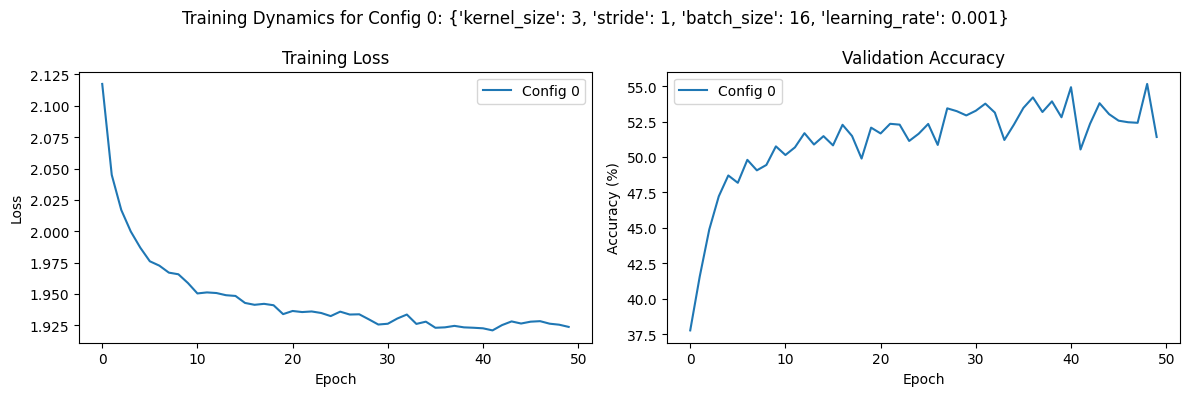

In [ ]:
plot_training_curves(finl_configs, finl_logs, combined = False)

## Final Sweep Observations



# Preview Sweep Results



In [ ]:
preview_results(results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       2          16          0.001      1.9556     48.6


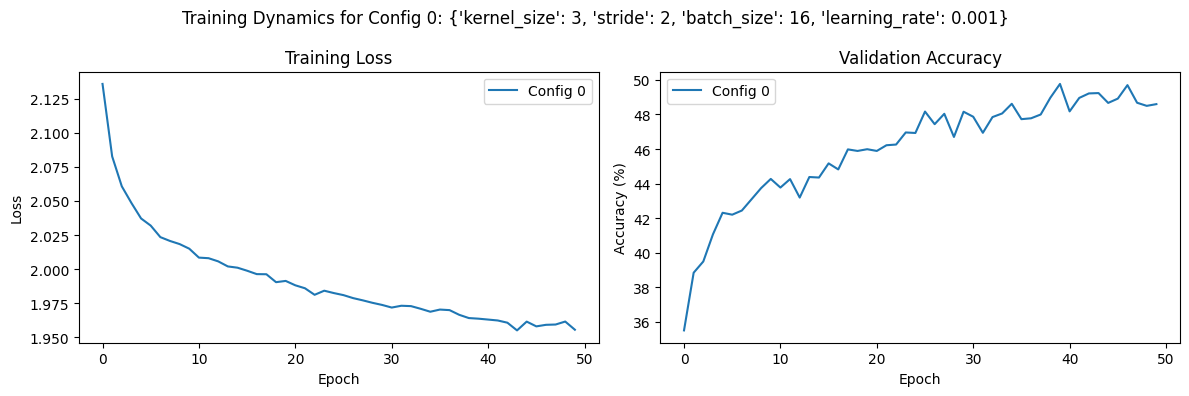

In [ ]:
plot_training_curves(configs, logs)